In [2]:
import torch,pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


/Users/pranavajay/miniconda3/envs/ptorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:


def show(tensor, ch=1, size=(28, 28), num=16):
    data = tensor.detach().cpu().view(-1, ch, size[0], size[1])  # Detach, move to CPU, and reshape
    #size[0] and 1 X and y axis
    grid = make_grid(data[:num], nrow=4)  # Create grid with the correct shape
    grid = grid.permute(1, 2, 0)  # Permute dimensions for display (h, w, ch)
    plt.imshow(grid)
    plt.show()


In [4]:
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.0001
loss_fn = nn.BCEWithLogitsLoss() #BCE with sigmoid

batches = 128
device = "mps" if torch.backends.mps.is_available() else "cpu"


In [5]:
dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle = True,batch_size = batches)

In [14]:
#Generator

def genBlock(inp,out):
    return nn.Sequential(
        nn.Linear(inp,out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )



class Generator(nn.Module):
    def __init__(self, z_dim=64,i_dim = 28*28,h_dim = 128) -> None: #i_dim -> output image dimension , hidden layer size -> 128,z_dim -> noise
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim,h_dim),
            genBlock(h_dim, h_dim*2),
            genBlock(h_dim*2, h_dim*4),
            genBlock(h_dim*4,h_dim*8),
            nn.Linear(h_dim*8,i_dim),
            nn.Sigmoid()#between 0 and one , pixel values
        )

    def forward(self,noise):
        return self.gen(noise)


def gen_noise(number,z_dim):
    return torch.randn(number,z_dim).to(device)



In [15]:
def discBlock(inp,out):
    return nn.Sequential(
        nn.Linear(inp,out),
        nn.LeakyReLU(0.2),
    )

class Discriminator(nn.Module):
    def __init__(self,i_dim = 28*28, h_dim=256) -> None:
        super().__init__()
        self.disc= nn.Sequential(
            discBlock(i_dim,h_dim*4), #Discriminator starts with high h_dim
            discBlock(h_dim*4,h_dim*2),
            discBlock(h_dim*2,h_dim),
            nn.Linear(h_dim,1),
            
        )

    def forward(self,image):
        return self.disc(image)
    
        
    
        

In [16]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr = lr)


disc =Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr = lr)

In [17]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([2, 9, 2, 0, 6, 4, 0, 3, 3, 5])


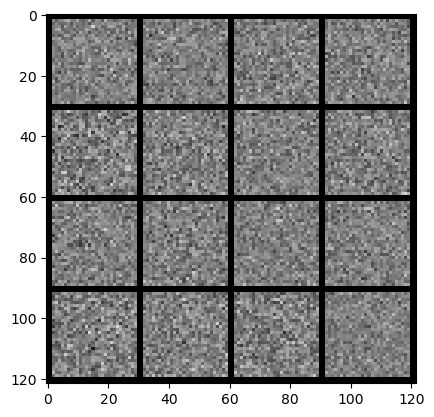

In [29]:
X,y = next(iter(dataloader))
print(X.shape,y.shape)
print(y[:10])

noise = gen_noise(batches,z_dim)
fake = gen(noise)
show(fake)